In [1]:
import sys
sys.path.append('../src/')
import torch
from tqdm.notebook import tqdm
import torch.nn as nn
import numpy as np
import cv2
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

# Data structures and functions for rendering
from pytorch3d.structures import Pointclouds
from pytorch3d.renderer import look_at_view_transform

from tools import render_pc_image
from tools import hidden_pts_removal
from tools import get_cam_frustum_pts

INFO - 2021-02-02 23:04:38,291 - topics - topicmanager initialized


In [2]:
# class FrustumVisibility(torch.autograd.Function):

#     @staticmethod
#     def forward(ctx, rewards, fov_mask):
#         rewards_fov = rewards * fov_mask
        
#         ctx.save_for_backward(fov_mask)
#         return torch.sum(rewards_fov)

#     @staticmethod
#     def backward(ctx, grad_output):
#         fov_mask, = ctx.saved_tensors
#         d_rewards = grad_output.clone() * fov_mask
#         return d_rewards, None

In [3]:
def rewards_from_pose(camera_dist_elev_azim, verts,
                      min_dist=1.0, max_dist=10.0,
                      img_width=1232, img_height=1616,
                      intrins= torch.tensor([[758.03967, 0.,        621.46572, 0.],
                                             [0.,        761.62359, 756.86402, 0.],
                                             [0.,        0.,        1.,        0.],
                                             [0.,        0.,        0.,        1.]]),
                      device=torch.device('cuda')):
    dist, elev, azim = camera_dist_elev_azim
    R, T = look_at_view_transform(dist, elev, azim, device=device)

    # transform points to camera frame
    R_inv = torch.transpose(torch.squeeze(R, 0), 0, 1)
    verts = torch.transpose(verts - torch.repeat_interleave(T, len(verts), dim=0).to(device), 0, 1)
    verts = torch.matmul(R_inv, verts)

    # get masks of points that are inside of the camera FOV
    dist_mask = (verts[2] > min_dist) & (verts[2] < max_dist)
    
    pts_homo = intrins[:3, :3].to(device) @ verts
    pts_homo[:2] /= pts_homo[2:3]
    fov_mask = (pts_homo[2] > 0) & \
               (pts_homo[0] > 1) & (pts_homo[0] < img_width - 1) & \
               (pts_homo[1] > 1) & (pts_homo[1] < img_height - 1)

    # HPR: remove occluded points
    # verts, occl_mask = hidden_pts_removal(verts.detach(), device=self.device)
    
    mask = torch.logical_and(dist_mask, fov_mask).to(device)
    reward = torch.sum(mask, dtype=torch.float)
    return reward
    
    
class FrustumVisibilityEst(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """
    @staticmethod
    def forward(ctx,
                camera_dist_elev_azim, verts,
                delta=0.1,  # small position and angular change for gradient estimation
                device=torch.device('cuda')):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        rewards = rewards_from_pose(camera_dist_elev_azim, verts)
        
        # calculate how the small rotation ddist=delta affects the amount of rewards, i.e. dr/ddist = ?
        camera_dist_elev_azim_ddist = camera_dist_elev_azim + torch.tensor([delta, 0.0, 0.0]).to(device)
        rewards_ddist = rewards_from_pose(camera_dist_elev_azim_ddist, verts) - rewards
        
        # calculate how the small rotation delev=delta affects the amount of rewards, i.e. dr/delev = ?
        camera_dist_elev_azim_delev = camera_dist_elev_azim + torch.tensor([0.0, delta, 0.0]).to(device)
        rewards_delev = rewards_from_pose(camera_dist_elev_azim_delev, verts) - rewards
        
        # calculate how the small rotation dazim=delta affects the amount of rewards, i.e. dr/ddist = ?
        camera_dist_elev_azim_dazim = camera_dist_elev_azim + torch.tensor([0.0, 0.0, delta]).to(device)
        rewards_dazim = rewards_from_pose(camera_dist_elev_azim_dazim, verts) - rewards
                
        ctx.save_for_backward(rewards_ddist, rewards_delev, rewards_dazim)
        return rewards

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        rewards_ddist, rewards_delev, rewards_dazim, = ctx.saved_tensors
        
        ddist = grad_output.clone() * rewards_ddist
        delev = grad_output.clone() * rewards_delev
        dazim = grad_output.clone() * rewards_dazim
                
        return torch.tensor([ddist, delev, dazim]).to(rewards_dazim.device), None

In [4]:
class Model(nn.Module):
    def __init__(self, points, dist_init, elev_init, azim_init):
        super().__init__()
        self.points = points
        self.device = points.device

        # Create optimizable parameters for pose of the camera.
        self.camera_dist_elev_azim = nn.Parameter(
            torch.as_tensor([dist_init, elev_init, azim_init], dtype=torch.float32).to(points.device))

        self.K, self.width, self.height = self.load_intrinsics()
        self.eps = 1e-6
        self.pc_clip_limits = torch.tensor([1.0, 10.])
        
        # self.frustum_visibility = FrustumVisibility.apply
        self.frustum_visibility = FrustumVisibilityEst.apply

    @staticmethod
    def load_intrinsics():
        width, height = 1232., 1616.
        K = torch.tensor([[758.03967, 0.,        621.46572, 0.],
                          [0.,        761.62359, 756.86402, 0.],
                          [0.,        0.,        1.,        0.],
                          [0.,        0.,        0.,        1.]]).to(device)
        K = K.unsqueeze(0)
        return K, width, height

    @staticmethod
    def get_dist_mask(points, min_dist=1.0, max_dist=5.0):
        # clip points between MIN_DIST and MAX_DIST meters distance from the camera
        dist_mask = (points[2] > min_dist) & (points[2] < max_dist)
        return dist_mask
    
    @staticmethod
    def get_fov_mask(points, img_height, img_width, intrins):
        # find points that are observed by the camera (in its FOV)
        pts_homo = intrins[:3, :3] @ points
        pts_homo[:2] /= pts_homo[2:3]
        fov_mask = (pts_homo[2] > 0) & (pts_homo[0] > 1) & \
                   (pts_homo[0] < img_width - 1) & (pts_homo[1] > 1) & \
                   (pts_homo[1] < img_height - 1)
        return fov_mask
    
    def to_camera_frame(self, verts, R, T):
        R_inv = R.squeeze().T
        verts_cam = R_inv @ (verts - torch.repeat_interleave(T, len(verts), dim=0).to(self.device)).T
        verts_cam = verts_cam.T
        return verts_cam

    def forward(self):
        rewards = self.frustum_visibility(self.camera_dist_elev_azim, self.points)
        loss = 1. / (rewards + self.eps)
        
        dist, elev, azim = self.camera_dist_elev_azim
        R, T = look_at_view_transform(dist, elev, azim, device=self.device)
        verts = self.to_camera_frame(self.points, R, T)
        
        # get masks of points that are inside of the camera FOV
        dist_mask = self.get_dist_mask(verts.T, self.pc_clip_limits[0], self.pc_clip_limits[1])
        fov_mask = self.get_fov_mask(verts.T, self.height, self.width, self.K.squeeze(0))

        mask = torch.logical_and(dist_mask, fov_mask)

        # remove points that are outside of camera FOV
        verts = verts[mask, :]
        return loss, verts

### Load point cloud

In [5]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")
# Set paths
obj_filename = "../pts/cam_pts_camera_0_1607456676.1540315.npz"
# obj_filename = "../pts/cam_pts_camera_0_1607456663.5413494.npz"
pts_np = np.load(obj_filename)['pts'].transpose()
verts = torch.tensor(pts_np).to(device)
# rgb = (verts - torch.min(verts)) / torch.max(verts - torch.min(verts)).to(device)
rgb = torch.zeros_like(verts)

point_cloud = Pointclouds(points=[verts], features=[rgb])

### Point cloud rendering parameters

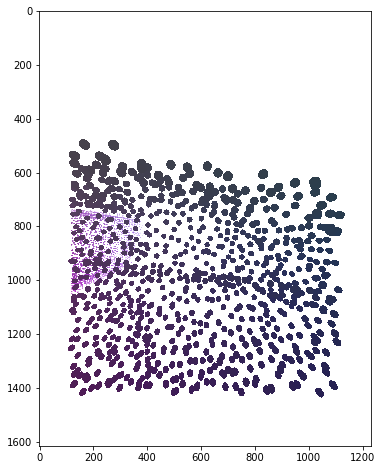

In [6]:
# Camera intrinsics
cam_info_K = (758.03967, 0.0, 621.46572, 0.0, 761.62359, 756.86402, 0.0, 0.0, 1.0)
width, height = 1232, 1616
K = torch.tensor([[758.03967, 0.,        621.46572, 0.],
                  [0.,        761.62359, 756.86402, 0.],
                  [0.,        0.,        1.,        0.],
                  [0.,        0.,        0.,        1.]]).to(device)
K = K.unsqueeze(0)

# Initialize a camera.
R = torch.eye(3).unsqueeze(0).to(device)
T = torch.Tensor([[0., 0., 0.]]).to(device)

image = render_pc_image(verts, R, T, K, height, width, device)

plt.figure(figsize=(8, 8))
plt.imshow(image.cpu().numpy());

### Define the model

In [7]:
# Initialize a model
model = Model(points=verts,
              dist_init=2.0,
              elev_init=10,
              azim_init=30).to(device)
# Create an optimizer. Here we are using Adam and we pass in the parameters of the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.5)

### Optimization loop

0.021276595070958138
Parameter containing:
tensor([ 2.5000, 10.5000, 30.5000], device='cuda:0', requires_grad=True)


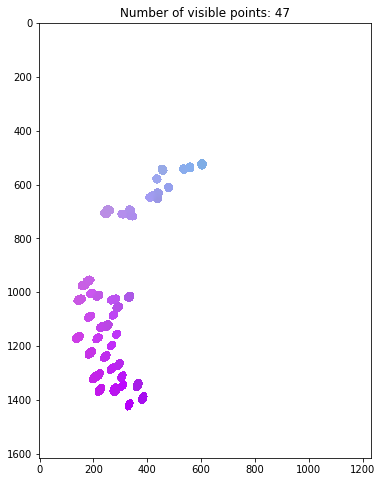

0.0021834061481058598
Parameter containing:
tensor([ 4.2846, 12.2368, 32.1135], device='cuda:0', requires_grad=True)


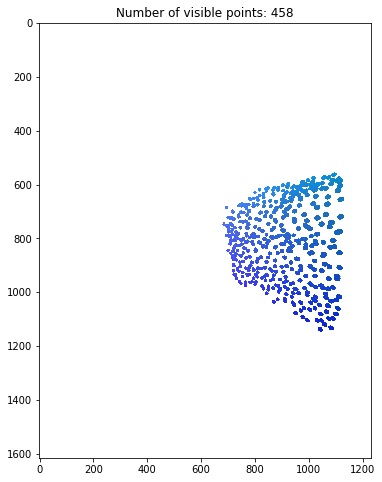

0.0021413275972008705
Parameter containing:
tensor([ 4.8365, 12.7579, 32.4882], device='cuda:0', requires_grad=True)


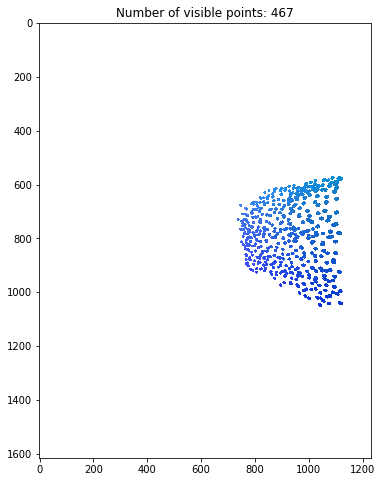

0.0021052630618214607
Parameter containing:
tensor([ 5.0649, 12.9516, 32.4931], device='cuda:0', requires_grad=True)


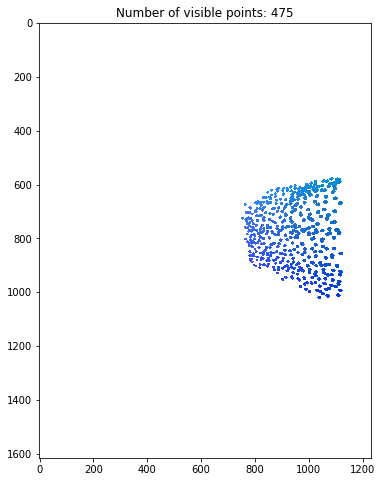

0.0020920501556247473
Parameter containing:
tensor([ 5.1690, 13.0256, 32.3511], device='cuda:0', requires_grad=True)


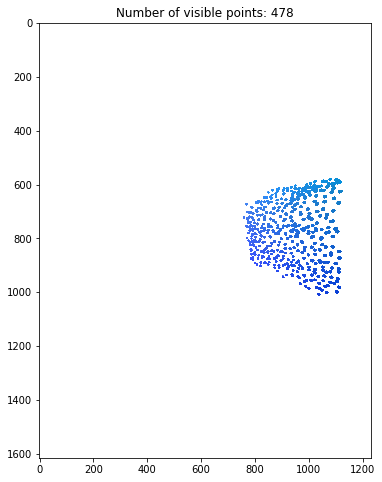

0.0020491802133619785
Parameter containing:
tensor([ 5.2364, 13.0530, 32.0886], device='cuda:0', requires_grad=True)


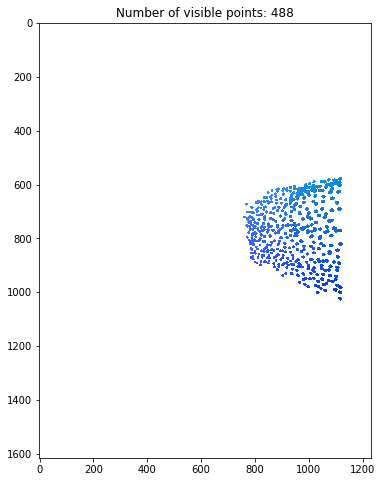

0.0019920319318771362
Parameter containing:
tensor([ 5.2918, 13.0283, 31.6564], device='cuda:0', requires_grad=True)


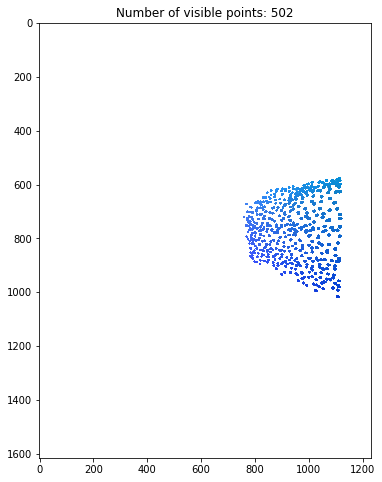

0.0019417476141825318
Parameter containing:
tensor([ 5.3413, 12.9653, 31.2446], device='cuda:0', requires_grad=True)


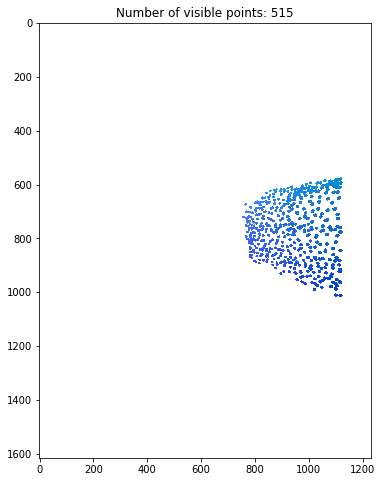

0.001912045874632895
Parameter containing:
tensor([ 5.3839, 12.9276, 30.8171], device='cuda:0', requires_grad=True)


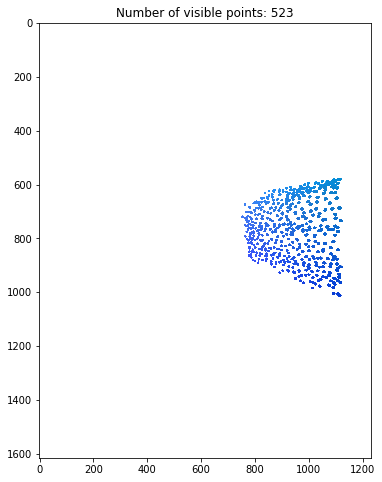

0.0018975331913679838
Parameter containing:
tensor([ 5.4203, 12.9062, 30.5177], device='cuda:0', requires_grad=True)


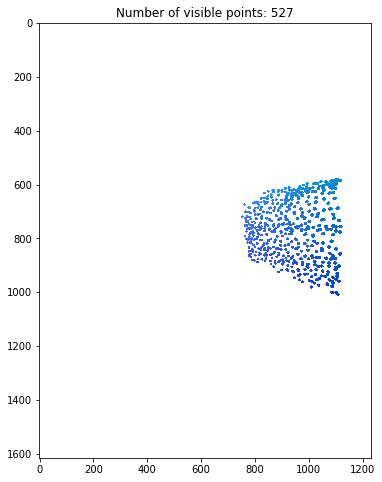

In [8]:
# Run optimization loop
loop = tqdm(range(100))
for i in loop:
    optimizer.zero_grad()
    loss, verts = model()
    loss.backward()
    optimizer.step()

    loop.set_description('Optimizing (loss %.4f)' % loss.data)

    if i % 10 == 0:
        print(loss.item())
        print(model.camera_dist_elev_azim)
        image = render_pc_image(verts, R, T, K, height, width, device)

        plt.figure(figsize=(8, 8))
        plt.imshow(image.detach().cpu().numpy());
        plt.title(f'Number of visible points: {verts.size()[0]}')
        plt.show()